In [1]:
import torch
import torch_geometric
import os
from glob import glob
import json
from torch_geometric.nn import radius, knn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.nn.pool import knn
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_undirected, subgraph
import random
from torch_geometric.data import Batch
from copy import deepcopy
from torch_geometric.nn.pool import knn_graph, radius_graph
import importlib
from importlib import reload
import math
from glob import glob
import sys
import time
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import networkx as nx
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
%matplotlib notebook
%matplotlib inline

In [2]:
contrast_vs_dir = '/xdisk/twheeler/jgaiser/ContrastVS/'
data_dir = contrast_vs_dir + 'data/'
GCPR_dir = data_dir + 'GCPR/'
pocket_embeds_dir = GCPR_dir + 'protein_embeds/'
active_embeds_dir = GCPR_dir + 'ligand_embeds/'
decoy_embeds_dir = data_dir + 'pdbbind/ligand_embeds/'
validation_pairs = torch.load(data_dir + 'pdbbind/VALIDATION_PAIRS_4-2.pt')

validation_ids = []
decoy_embeds = []
pdbbind_ligands = []

for p in validation_pairs:
    validation_ids.append(p[1].name.split('_')[0])
    
for d in glob(decoy_embeds_dir + '/*.pyg'):
    pdb_id = d.split('/')[-1].split('_')[0]
    if pdb_id in validation_ids:
        decoy_embeds.append(torch.load(d))
    else:
        pdbbind_ligands.append(torch.load(d))

In [3]:
pdbbind_batch = DataLoader(pdbbind_ligands, batch_size=128, shuffle=False)

In [6]:
edge_d_obs = []
spatial_d_obs = []

def quantize_distances(mol_pos, n=27, randomize=False):
    vox_min = torch.floor(torch.min(mol_pos, dim=0).values)-5
    vox_max = torch.ceil(torch.max(mol_pos, dim=0).values)+5
    quantized_pos = [None for _ in range(mol_pos.size(0))]
    
    vox_grid = torch.cartesian_prod(torch.arange(vox_min[0], vox_max[0]),
                                    torch.arange(vox_min[1], vox_max[1]),
                                    torch.arange(vox_min[2], vox_max[2]))
    
    knn_ei = knn(vox_grid, mol_pos, n)
    
    for bi in torch.unique(knn_ei[0]):
        k_nearest_voxels = knn_ei[1][torch.where(knn_ei[0] == bi)[0]]
        
        if randomize: 
            k_nearest_voxels = k_nearest_voxels[torch.randperm(k_nearest_voxels.size(0))]
            
        quantized_pos[bi.item()] = vox_grid[k_nearest_voxels[0]]
    
    quantized_pos = torch.vstack(quantized_pos)
    return quantized_pos

def get_distance_data(mol, atom_idx):
    mol = deepcopy(mol)
    edge_distance_obs = []
    spatial_distance_obs = []
    mol.pos = quantize_distances(mol.pos)
    
    observed_atoms = torch.tensor([atom_idx])
    
    for k in range(1, mol.x.size(0)):
        within_k = k_hop_subgraph(atom_idx, k, mol.edge_index)[0]
        k_hop_neighbors = torch.tensor(np.setdiff1d(within_k, observed_atoms))
        
        if k_hop_neighbors.size(0) == 0:
            break
            
        observed_atoms = torch.hstack((observed_atoms, k_hop_neighbors))
        spatial_distances = torch.cdist(mol.pos[atom_idx].unsqueeze(0), 
                                        mol.pos[k_hop_neighbors]).squeeze(0).tolist()
        
        edge_distance_obs += [k for _ in spatial_distances] 
        spatial_distance_obs += spatial_distances
        
    return edge_distance_obs, spatial_distance_obs

# for li, lg in enumerate(pdbbind_ligands):
#     ed, sd = get_distance_data(lg, random.randint(0,lg.x.size(0)-1))
#     edge_d_obs += ed
#     spatial_d_obs += sd

In [101]:
dists = []

li = 0

for li, lg in enumerate(pdbbind_ligands):
    li += 1
    
    if li > 5000:
        break
    
    quantized_pos = quantize_distances(lg.pos)
    random_mol_atom = random.randint(0, lg.x.size(0)-1)
    quant_cluster = quantized_pos[k_hop_subgraph(random_mol_atom, 2, lg.edge_index)[0]]
    ds = torch.cdist(quant_cluster, quant_cluster)
    ds = ds[ds != 0]
    dists += ds.tolist()
    
#     min_corner = quant_cluster.min(0).values
#     max_corner = quant_cluster.max(0).values
#     dists.append(torch.norm(min_corner-max_corner).item())
    
    

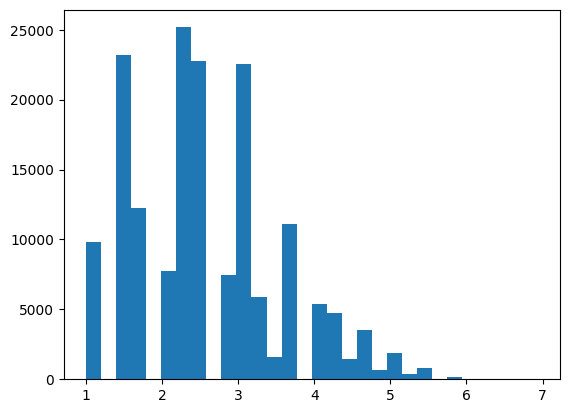

In [8]:
ABCs = []
BCDs = []
dihedrals = []
dh2s = []

def get_angle(v1, v2):
    # Calculate dot product and norms
    dot_product = torch.dot(v1, v2)
    norm_v1 = torch.norm(v1)
    norm_v2 = torch.norm(v2)

    # Calculate the angle in radians and then convert to degrees
    cos_theta = dot_product / (norm_v1 * norm_v2)
    theta = torch.acos(cos_theta)  # Angle in radians
    return theta

def get_angle_data(A, B, C, D=None, E=None):
    dihedral = None
    dh2 = None
    # Compute vectors
    AB = B - A
    BC = C - B
    
    theta = get_angle(AB, BC)
    
    if D is not None:
        CD = D - C
        ABC_normal = torch.cross(AB, BC)
        dihedral = get_angle(ABC_normal, CD)
        
    if E is not None:
        DE = E - D
        BCD_normal = torch.cross(BC, CD)
        dh2 = get_angle(BCD_normal, DE)
        
    return theta, dihedral, dh2
    
for li, lg in enumerate(pdbbind_ligands):
    lg.pos = quantize_distances(lg.pos)
    
    atom_chain = [random.randint(0, lg.x.size(0)-1)]
   
    for i in range(4):
        sinks = lg.edge_index[1][lg.edge_index[0] == atom_chain[i]]
        sinks = sinks[torch.randperm(sinks.size(0))]
        
        sink_i = 0
        
        if sinks.size(0) == 0:
            break
            
        random_sink = sinks[sink_i].item()
        
        while random_sink in atom_chain:
            sink_i += 1
            
            if sink_i >= sinks.size(0):
                break
                
            random_sink = sinks[sink_i].item()
            
        if random_sink in atom_chain:
            break

        if math.isnan(random_sink):
            print('waaat')
            break
            
        atom_chain.append(random_sink)
    
    if len(atom_chain) < 5:
        continue
        
    ABC, dihedral, dh2 = get_angle_data(*lg.pos[atom_chain])
#     BCD = get_angle_data(*lg.pos[atom_chain[1:]])
    
    if torch.any(torch.isnan(torch.hstack((ABC, dihedral, dh2)))):
        continue
        
    ABCs.append(ABC)
    dihedrals.append(dihedral)
    dh2s.append(dh2)
    

KeyboardInterrupt: 

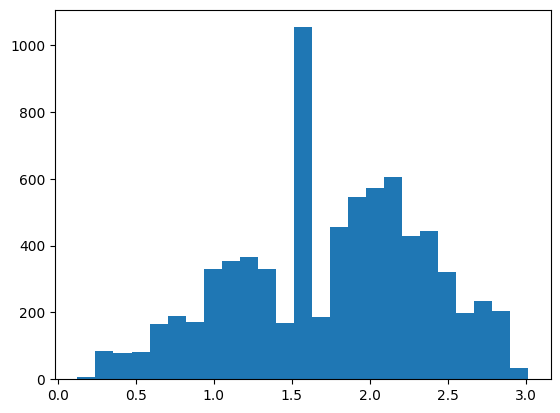

In [60]:
dhs = torch.hstack(dihedrals).numpy()
dhs_2 = torch.hstack(dh2s).numpy()
abcs = torch.hstack(ABCs).numpy()

# bins = plt.hist2d(abcs, dhs, bins=50)
bins = plt.hist(abcs, bins=25)
# plt.show()

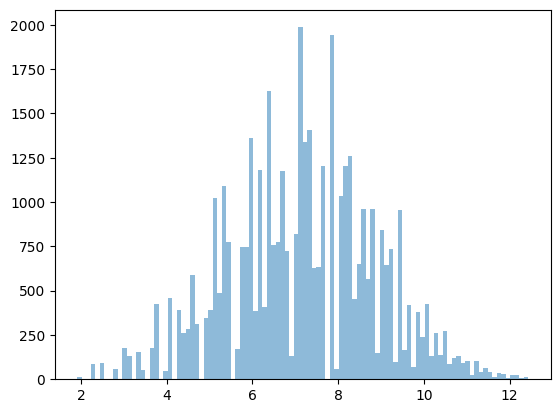

tensor([0.1626, 0.3956, 0.5860, 1.0000, 0.7553, 0.6739])

In [27]:
def plot_histogram_data(data, bins=20):
    plt.clf()
    r = [x.item() for x in [data.mean()-data.std()*3, data.mean()+data.std()*3]]
    plt.hist(data, bins=bins, range=r, alpha=0.5)
    plt.show()
    
def histogram_scoring_function(data, bins=25):
    hist_vals, bin_edges = torch.histogram(data, bins)
    hist_vals = hist_vals / max(hist_vals)
    
    def hist_score(values): 
        buckets = torch.bucketize(values, bin_edges)
        buckets[buckets == 0] = 1
        buckets[buckets > hist_vals.size(0)] = hist_vals.size(0)
        buckets = buckets-1

        return hist_vals[buckets]
    
    return hist_score

def get_atom_d_score_function(spatial_distances, 
                              edge_distances, 
                              bins=25, 
                              max_ed=10):
    
    hist_score_functions = [histogram_scoring_function(spatial_distances[torch.where(edge_distances==i)[0]], bins) 
                           for i in range(1, max_ed)]

    def df(spatial_dist, edge_dist):
        return hist_score_functions[edge_dist-1](spatial_dist)
    
    return df


sd_obs = torch.tensor(spatial_d_obs)

ed_obs = torch.tensor(edge_d_obs)

atom_d_score = get_atom_d_score_function(sd_obs, ed_obs)

ed_test_i = 7 
plot_histogram_data(sd_obs[torch.where(ed_obs==ed_test_i)[0]], 100)
atom_d_score(torch.arange(4,10), ed_test_i)

In [20]:
pl_pairs = []

for pi, pocket_embed_f in enumerate(glob(pocket_embeds_dir + '*.pyg')):
    p_pdb_id = pocket_embed_f.split('/')[-1].split('_')[0]
    
    for ligand_embed_f in glob(active_embeds_dir + '*.pyg'):
        if p_pdb_id in ligand_embed_f:
            pl_pairs.append((torch.load(pocket_embed_f), 
                             torch.load(ligand_embed_f)))
            

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def all_pairs_cos(a,b):
    with torch.no_grad():
        cos = torch.nn.CosineSimilarity(dim=2)
        a = a.unsqueeze(1).to(device)
        b = b.unsqueeze(0).to(device)
        return(cos(a,b).cpu())
    
def cos_dist(a,b):
    return 1 - all_pairs_cos(a,b)

def a_in_b_mask(a, b):
    a_exp = a.unsqueeze(1)
    b_exp = b.unsqueeze(0)
    return torch.any(a_exp == b_exp, dim=1)

def get_n_closest(a, b, n, dist_func=cos_dist):
    d_vals, d_index = torch.sort(dist_func(a,b))
    return d_vals[:,:n], d_index[:,:n]

def get_k_hop_neighborhoods(mol, atom_idx, max_k):
    k_hop_neighborhoods = []
    observed_atoms = torch.tensor([atom_idx])
    
    for k in range(1, max_k+1):
        within_k = k_hop_subgraph(atom_idx, k, mol.edge_index)[0]
        k_hop_neighbors = torch.tensor(np.setdiff1d(within_k, observed_atoms))
        
        if k_hop_neighbors.size(0) == 0:
            break
            
        observed_atoms = torch.hstack((observed_atoms, k_hop_neighbors))
        k_hop_neighborhoods.append(k_hop_neighbors)
        
    return k_hop_neighborhoods


In [155]:
def id_interaction_points(pg, eval_data):
    pocket_point_score = torch.zeros(pg.x.size(0))  
    pocket_point_mean = torch.zeros_like(pg.x)
    
    for bi, b in enumerate(eval_data):
        print(bi)
        p_neighbor_dist, p_neighbor_idx = get_n_closest(b.x, pg.x, 5)
        true_neighbors = torch.where(p_neighbor_dist < 0.1)
        
        for m_idx in torch.unique(true_neighbors[0]):
            closest_idx = true_neighbors[1][true_neighbors[0]==m_idx]
            p_idx = p_neighbor_idx[m_idx, closest_idx]
            
            pocket_point_score[p_idx] += 1
            pocket_point_mean[p_idx] += b.x[m_idx]
            
    
    return pocket_point_score, pocket_point_mean
    
ps, pm = id_interaction_points(pl_pairs[123][0], pdbbind_batch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


<BarContainer object of 1365 artists>

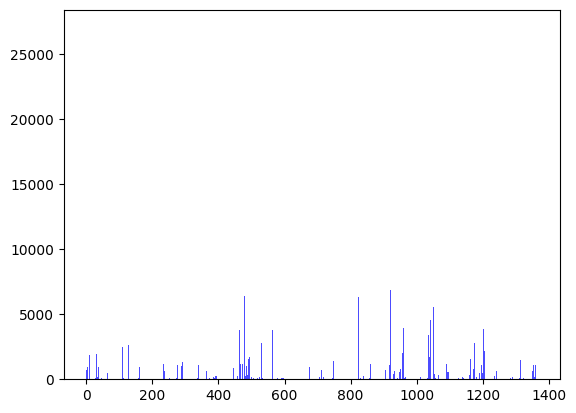

In [156]:
plt.bar(range(len(ps)), ps, color='blue', alpha=0.7)

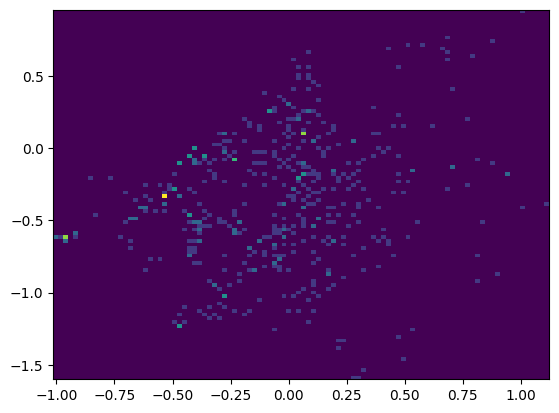

In [211]:
best_indices = torch.sort(ps, descending=True).indices[:500]
mean_embeds = pm[best_indices] / ps[best_indices].unsqueeze(1)

bins = plt.hist2d(dim1.numpy(), dim2.numpy(), bins=100)

In [62]:
torch.where(ps > 0)[0].size(0)

464

In [24]:
def find_k_hop_neighbors(g, k):
    edge_index = g.edge_index
    num_nodes = g.x.size(0)
    # Convert edge_index to dense adjacency matrix
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
    # Identity matrix to start the multiplication (A^0)
    prev = torch.eye(num_nodes, dtype=torch.bool, device=edge_index.device)

    # List to hold edge indices for k hops
    hop_pairs = []

    for _ in range(k):
        # Multiply previous power with adjacency matrix (A^k)
        next_adj = torch.matmul(adj.float(), prev.float())
        # Get pairs that are exactly k-hops away (nonzero entries in next_adj that were zero in prev)
        next_adj = (next_adj > 0) & ~prev
        # Update previous adjacency to include paths of length <= k
        prev = prev | next_adj.bool()
        # Convert to edge_index format
        hop_pairs.append(dense_to_sparse(next_adj)[0])

    return hop_pairs

def get_hop_pairs(data, max_hops=4):
    num_nodes = data.num_nodes
    hop_data = []

    # Calculate pairs for each hop from 1 to max_hops
    hop_pairs = find_k_hop_neighbors(data.edge_index, num_nodes, max_hops)
    
    # Process pairs into the required format
    for hop in range(max_hops):
        if len(hop_pairs[hop][0]) == 0:
            # Handle graphs with isolated components or small number of nodes
            hop_data.append(torch.empty((0, 2), dtype=torch.long))
        else:
            pairs = torch.stack(hop_pairs[hop], dim=1)
            hop_data.append(pairs)

    # Stack along new dimension to get a tensor of shape [max_hops, N_k, 2]
    return torch.stack(hop_data)

def print_matrix(m):
    for r in m:
        print(' '.join(['%s' % x for x in r.int().tolist()]))


mg = pl_pairs[8][1]

for r in find_k_hop_neighbors(mg, 3):
    print(r)


tensor([[ 0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,
          7,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 15,
         16, 17, 18, 19],
        [ 1,  5, 15, 16,  0,  2,  1,  3,  2,  4,  3,  5, 17,  0,  4,  6,  5,  7,
          6,  8,  7,  9, 18,  8, 10,  9, 11, 10, 12, 11, 13, 19, 12, 14, 13,  0,
          0,  4,  8, 12]])
tensor([[ 0,  0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  9,  9,  9, 10, 10, 11, 11,
         11, 12, 12, 13, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 18, 18, 19, 19],
        [ 2,  4,  6,  3,  5, 15, 16,  0,  4,  1,  5, 17,  0,  2,  6,  1,  3,  7,
         15, 16, 17,  0,  4,  8,  5,  9, 18,  6, 10,  7, 11, 18,  8, 12,  9, 13,
         19, 10, 14, 11, 19, 12,  1,  5, 16,  1,  5, 15,  3,  5,  7,  9, 11, 13]])
tensor([[ 0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  6,
          6,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8, 

In [46]:
si = torch.arange(64).reshape(-1,8)
print(si)

for i in range(si.size(0)-1):
    print(torch.cartesian_prod(si[i], si[i+1]))
    print(si[i], si[i+1])

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53, 54, 55],
        [56, 57, 58, 59, 60, 61, 62, 63]])
tensor([[ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 1,  8],
        [ 1,  9],
        [ 1, 10],
        [ 1, 11],
        [ 1, 12],
        [ 1, 13],
        [ 1, 14],
        [ 1, 15],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 2, 11],
        [ 2, 12],
        [ 2, 13],
        [ 2, 14],
        [ 2, 15],
        [ 3,  8],
        [ 3,  9],
        [ 3, 10],
        [ 3, 11],
        [ 3, 12],
        [ 3, 13],
        [ 3, 14],
        [ 3, 15],
        [ 4,  8],
        [ 4,  9],
        [ 4, 10],
        [ 4, 11],
        [ 4, 12

In [56]:
def construct_directed_graph(pg, mg, n=15, edge_k=3, min_d_score=0.7):
    x, p_indices = get_n_closest(mg.x, pg.x, n) 
    x = x.flatten()
    
    structured_index = torch.arange(x.size(0)).reshape(mg.x.size(0),-1)
    
    pos = pg.pos[p_indices].reshape(-1, 3)
    
    ei_segments = []
    ea = []
    
    for ai in range(structured_index.size(0)-1):
        zero_ei = torch.cartesian_prod(structured_index[ai], 
                                       structured_index[ai+1]).T
        ei_segments.append(zero_ei)
        ea.append(torch.zeros(zero_ei.size(1)))
    
    k_i = 0
    
    for k_hop_pairs in find_k_hop_neighbors(mg, edge_k):
        k_i += 1
        
        mask = k_hop_pairs[1] - k_hop_pairs[0]
        mask[mask < 0] = 0
        mask = mask.bool()
        
        k_hop_pairs = k_hop_pairs[:, mask]
        
        k_source_pos = pos[structured_index[k_hop_pairs[0]]]
        k_sink_pos = pos[structured_index[k_hop_pairs[1]]]
        
        spatial_dist = torch.norm(k_source_pos.unsqueeze(2) - k_sink_pos.unsqueeze(1), dim=3)
        distance_scores = atom_d_score(spatial_dist, k_i) 
        
        i,j,l = torch.where(distance_scores > min_d_score)
        
        ei_segments.append(torch.vstack((k_hop_pairs[0,i]*n + j, 
                                         k_hop_pairs[1,i]*n + l)))
        
        ea.append(1-x[k_hop_pairs[1,i]*n + l])
            
    x = torch.hstack((torch.tensor(0), x, torch.tensor(0)))
    pos = torch.vstack((torch.tensor([[0,0,0]]), pos, torch.tensor([[0,0,0]])))
    ei = torch.hstack(ei_segments)+1
    ea = torch.hstack(ea)
#     ea[ea == 0] = -1
    
    start_sinks = structured_index[0]+1
    start_edges = torch.vstack((torch.zeros(start_sinks.size(0)), start_sinks))
    start_ea = 1-x[start_sinks]
    
    stop_sources = torch.arange(x.size(0)-1-n, x.size(0)-1)
#     stop_sources = torch.arange(1, x.size(0)-1)
    stop_edges = torch.vstack((stop_sources, 
                               torch.zeros(stop_sources.size(0)).fill_(x.size(0)-1)))
    
    stop_ea = torch.zeros(stop_sources.size(0))
    
    ei = torch.hstack((ei, start_edges, stop_edges))
    ea = torch.hstack((ea, start_ea, stop_ea))
    
    return Data(x=x, edge_index=ei, weight=-1*ea, pos=pos)

p_i = 0    

def get_edge(source, sink, ei):
    source_idx = torch.where(ei[0]==source)[0]
    sink_idx = torch.where(ei[1]==sink)[0]
    return torch.tensor(np.intersect1d(source_idx,sink_idx))

def get_pm_score(p, m):
    g = construct_directed_graph(p,m)
    x, ei, ea = (g.x, g.edge_index, g.weight)
    
    data = Data(edge_index=ei, weight=ea, num_nodes=x.size(0))
    g = torch_geometric.utils.to_networkx(data, edge_attrs=['weight'])
    bf_out = nx.bellman_ford_path(g, 0, ei[1].max().item())
    
    scores = []
    
    for i in range(len(bf_out)-1):
        scores.append(ea[get_edge(bf_out[i], bf_out[i+1], ei)].min().item())
        
    
#     print(scores)
    return -1*(sum(scores) / len(scores))
    
scoores = []
pgraphs = []
ngraphs = []

for p,m in pl_pairs:
    p_i += 1
    p_score = get_pm_score(p,m)
    n_scores = []
    
    rs = random.sample(decoy_embeds, 100)
    for d in rs:
        nsc = get_pm_score(p, d)
        n_scores.append(nsc)
        
    n_scores = torch.tensor(n_scores)
    
    final_score = 1-(n_scores[n_scores > p_score].size(0) / n_scores.size(0))
    print(final_score)
    scoores.append(final_score)
    print('--', sum(scoores) / len(scoores))
    print('---')


0.78
-- 0.78
---
0.9
-- 0.8400000000000001
---
0.5800000000000001
-- 0.7533333333333334
---
0.78
-- 0.76
---
1.0
-- 0.808
---
0.0
-- 0.6733333333333333
---
0.76
-- 0.6857142857142857
---
0.65
-- 0.68125
---
0.27
-- 0.6355555555555557
---
0.88
-- 0.66
---
0.87
-- 0.6790909090909092
---
0.4
-- 0.6558333333333334
---
0.65
-- 0.6553846153846155
---
0.84
-- 0.6685714285714287
---
0.98
-- 0.6893333333333335
---
0.9
-- 0.7025000000000001
---


KeyboardInterrupt: 

In [ ]:
0.74
-- 0.74
---
0.92
-- 0.8300000000000001
---
0.62
-- 0.7600000000000001
---
0.64
-- 0.7300000000000001
---
0.99
-- 0.782
---
0.0
-- 0.6516666666666667
---
0.6599999999999999
-- 0.6528571428571429
---
0.61
-- 0.6475000000000001
---
0.85
-- 0.67
---
0.87
-- 0.6900000000000001
---

In [253]:
pdists = []
ndists = []

def get_bf_path_data(dag, m_count):
    structured_ppos = dag.pos[1:-1].reshape(m_count, -1, 3)
    
    avg_dist = torch.norm(structured_ppos.unsqueeze(2) -
                          structured_ppos.unsqueeze(1), dim=3).mean(dim=2).flatten()
    
    dag_nx = torch_geometric.utils.to_networkx(dag, edge_attrs=['weight'])
    bf_out = torch.tensor(nx.bellman_ford_path(dag_nx, 0, dag.edge_index[1].max().item())).long()[1:-1]
    
    if bf_out[-1] < avg_dist.size(0):
        return avg_dist[bf_out[1:-1]]
    
    return None
    
for p,m in pl_pairs:
    dag = construct_directed_graph(p, m, n=15, edge_k=3, min_d_score=0.7)
    dist_data = get_bf_path_data(dag, m.x.size(0))
    if dist_data is not None:
        pdists.append(dist_data)
    
    rs = random.sample(decoy_embeds, 250)
    for d in rs:
        ndag = construct_directed_graph(p, d, n=15, edge_k=3, min_d_score=0.7)
        ndist_data = get_bf_path_data(ndag, d.x.size(0))
        
        if ndist_data is not None:
            ndists.append(ndist_data)
        break
        
pdists = torch.hstack(pdists)
ndists = torch.hstack(ndists)

In [248]:
pdists = torch.hstack(pdists)
ndists = torch.hstack(ndists)

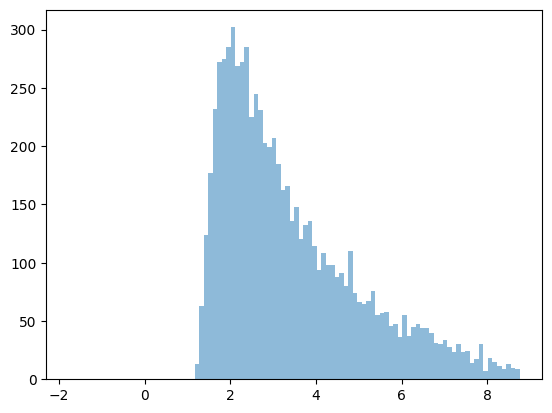

In [257]:
plot_histogram_data(pdists, bins=100)

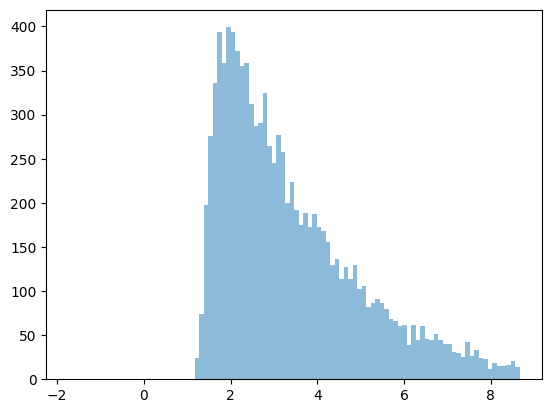

In [256]:
plot_histogram_data(ndists, bins=100)

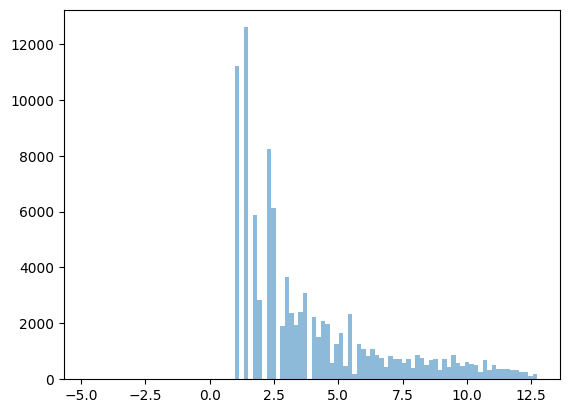

In [182]:
plot_histogram_data(p_NE_distances[:100000], bins=100)

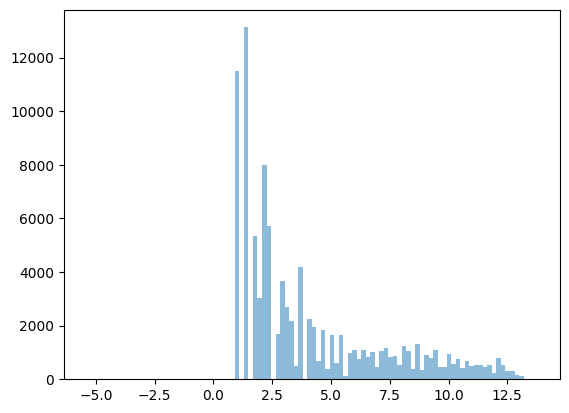

In [183]:
plot_histogram_data(n_NE_distances[:100000], bins=100)

In [179]:
print(n_NE_distances[:100], p_NE_distances[:100])

tensor([ 1.4142,  4.0000,  1.0000,  1.0000, 12.9615, 12.7279,  1.7321,  3.0000,
         1.0000,  2.0000,  1.4142, 12.4499, 12.3693,  2.2361,  1.4142,  4.2426,
         1.7321,  1.0000, 13.1909, 12.2474,  1.0000,  3.3166,  2.2361,  1.4142,
         1.4142, 11.8743, 11.8743,  1.0000,  4.0000,  4.2426,  3.0000,  4.1231,
        12.9615, 11.7473,  3.3166,  1.0000,  4.1231,  4.4721,  5.0990, 11.4455,
        11.7047,  4.5826,  1.0000,  1.7321,  3.0000,  1.4142, 12.8452, 12.3693,
         1.4142,  2.0000,  1.4142,  2.2361,  2.2361, 12.0830, 12.0830,  2.4495,
         1.0000,  1.0000,  4.1231,  1.4142, 12.3693, 11.8743,  1.4142,  3.1623,
         1.4142,  1.0000,  1.0000, 11.5758, 11.4891,  1.4142, 12.9615, 13.1909,
        12.9615, 12.8452, 12.3693,  7.3485, 13.0767, 12.8452, 12.2066, 11.8322,
        12.5698,  8.1854,  7.0000, 12.6886, 12.7279, 12.2474, 11.7473, 12.3693,
        11.8743,  7.3485, 11.8743, 11.8743, 12.4499, 11.0454, 12.3288,  1.0000,
         1.0000, 11.4455,  1.7321,  1.00

In [104]:
a = torch.arange(14*5*3).reshape(14,5,3)
b = torch.arange(14*5*3).reshape(14,5,3) / 2

print(a[0],b[0])

torch.norm(a.unsqueeze(2) - b.unsqueeze(1), dim=3).shape

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]]) tensor([[0.0000, 0.5000, 1.0000],
        [1.5000, 2.0000, 2.5000],
        [3.0000, 3.5000, 4.0000],
        [4.5000, 5.0000, 5.5000],
        [6.0000, 6.5000, 7.0000]])


torch.Size([14, 5, 5])

In [10]:
def construct_directed_graph(pg, mg, n=15, edge_k=2, min_d_score=0.25):
    x, p_indices = get_n_closest(mg.x, pg.x, n) 
    x = x.flatten()
    
    pos = pg.pos[p_indices].reshape(-1, 3)
    batch = torch.repeat_interleave(torch.arange(mg.x.size(0)), n, 0)
    
    ei_segments = []
    ea = []
    
    
    for ai in torch.unique(batch):
        i_node_indices = torch.where(batch == ai)[0]
        
        for k, k_neighborhood in enumerate(get_k_hop_neighborhoods(mg, ai.item(), edge_k)):
            j_node_indices = torch.where(a_in_b_mask(batch, k_neighborhood))[0]
            
            ij_distances = torch.cdist(pos[i_node_indices].to(device), 
                                       pos[j_node_indices].to(device)).cpu()
            
            # true k is NOT zero indexed
            ij_scores = atom_d_score(ij_distances, k+1)
            src, sink = torch.where(ij_scores > min_d_score)
            
            if src.size(0) == 0:
                continue
            
            source_idx = i_node_indices[src]
            sink_idx = j_node_indices[sink]
            
            directed_indices = torch.where(sink_idx > source_idx.max())[0]
            ei_segments.append(torch.vstack((source_idx, sink_idx))[:, directed_indices])
            
#             # MODIFY BY ij_score??
#             ea.append(1-x[sink_idx][directed_indices]*ij_scores[src[directed_indices], 
#                                                            sink[directed_indices]])
            ea.append(1-x[sink_idx][directed_indices])
            
    x = torch.hstack((torch.tensor(0), x, torch.tensor(0)))
    
    ei = torch.hstack(ei_segments)+1
    
    ea = torch.hstack(ea)
#     ea[ea == 0] = -1
    
    start_sinks = torch.where(batch==batch.min())[0]+1
    start_edges = torch.vstack((torch.zeros(start_sinks.size(0)), start_sinks))
    start_ea = 1-x[start_sinks]
    
#     stop_sources = torch.where(batch==batch.max())[0]+1
    stop_sources = torch.arange(x.size(0)-1)
    stop_edges = torch.vstack((stop_sources, 
                               torch.zeros(stop_sources.size(0)).fill_(x.size(0)-1)))
    
    stop_ea = torch.zeros(stop_sources.size(0))
    
    ei = torch.hstack((ei, start_edges, stop_edges))
    ea = torch.hstack((ea, start_ea, stop_ea))
    
    return x, ei, -1*ea

p_i = 0    

def get_edge(source, sink, ei):
    source_idx = torch.where(ei[0]==source)[0]
    sink_idx = torch.where(ei[1]==sink)[0]
    return torch.tensor(np.intersect1d(source_idx,sink_idx))

def get_pm_score(p, m):
    x, ei, ea = construct_directed_graph(p,m)
    
    data = Data(edge_index=ei, weight=ea, num_nodes=x.size(0))
    g = torch_geometric.utils.to_networkx(data, edge_attrs=['weight'])
    bf_out = nx.bellman_ford_path(g, 0, ei[1].max().item())
    
    scores = []
    
    for i in range(len(bf_out)-1):
        scores.append(ea[get_edge(bf_out[i], bf_out[i+1], ei)].min().item())
        
    
#     print(scores)
    return -1*(sum(scores) / len(scores))
    
scoores = []

for p,m in pl_pairs:
    p_i += 1
    p_score = get_pm_score(p,m)
    n_scores = []
    
    rs = random.sample(decoy_embeds, 50)
    
    for d in rs:
        nsc = get_pm_score(p, d)
        graph_construction_time += ctime
        total_time += ttime
        n_scores.append(nsc)
        
    n_scores = torch.tensor(n_scores)
    
    final_score = 1-(n_scores[n_scores > p_score].size(0) / n_scores.size(0))
    print(final_score)
    scoores.append(final_score)
    print('--', sum(scoores) / len(scoores))
    print('---')
    
    

tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
         144., 145., 146., 1

SystemExit: 

/home/u1/jgaiser/.conda/envs/vs-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# scores_3 = scoores

In [25]:
import time
validation_batch = DataLoader(decoy_embeds, batch_size=64, shuffle=False)

start = time.time()
final_scores = []

def score_complex(p, m, batch=None):
    atom_cos = torch.sort(all_pairs_cos(m, p), dim=1, descending=True).values[:, :25]
    scores = []
    
    if batch==None:
        batch = torch.zeros(atom_cos.size(0))
    
    for bi in torch.unique(batch):
        scores.append(atom_cos[torch.where(batch==bi)[0]].mean().item())
        
    return torch.tensor(scores)
    

for p,m in pl_pairs:
    pos_score = score_complex(p.x, m.x).item()
    
    neg_scores = []
    for batch in validation_batch: 
        neg_scores += score_complex(p.x, batch.x, batch.batch)
        
    neg_scores = torch.tensor(neg_scores)
    final_score = torch.where(neg_scores < pos_score)[0].size(0) / neg_scores.size(0)
    print(final_score)
    final_scores.append(final_score)
    print(sum(final_scores) / len(final_scores))
    print('-----')

0.59
0.59
-----
0.84875
0.719375
-----
0.66875
0.7025
-----
0.84375
0.7378125
-----
0.9775
0.78575
-----


KeyboardInterrupt: 

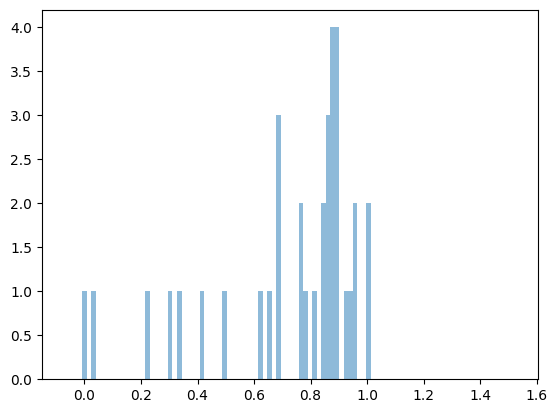

In [49]:
# cos_scores = final_scores    
plot_histogram_data(torch.tensor(scoores), bins=100)